In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "20" 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

from tqdm.auto import tqdm as tqdm_auto
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import importlib
from scipy import stats 

import torch
import torch.cuda
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
import pytorch_lightning as pl

import matplotlib.colors as clr

In [3]:
import dataset_regressiondiffusion as dataset
importlib.reload(dataset)


from lit_regressor import RNARegressor
import legnet_difgenerator
import legnet_classifier

In [4]:
batch_size = 4*1024
num_workers = 8
batch_per_epoch = 1
device= torch.device('cuda:0')
CELL_TYPE_FILTER = 'c6'
SEQ_LEN = 50 # UTR5, if UTR3 -> 240
epoch = 139
np.random.seed(seed=42)
num = 1


In [5]:
PATH_FROM = '../../../data/UTR5_zinb_norm_singleref_2023-05-23.csv'
df = pd.read_csv(PATH_FROM)

df = df[df.cell_type == CELL_TYPE_FILTER].reset_index(drop=True)
scores = (df['1']*1+df['2']*2+df['3']*3+df['4']*4) / df[['1', '2', '3', '4']].sum(axis=1)
df['mass_center'] = scores

In [6]:
df['A'] = df["seq"].str.count('A')/SEQ_LEN
df['C'] = df["seq"].str.count('C')/SEQ_LEN
df['G'] = df["seq"].str.count('G')/SEQ_LEN
df['T'] = df["seq"].str.count('T')/SEQ_LEN

subdf = df.sort_values(by='mass_center', ascending = True).reset_index(drop=True)
subdf = subdf.drop(['1','2','3','4'], axis=1)


In [7]:
subdf

,seq,cell_type,replicate,fold,mass_center,A,C,G,T
0,GCCCGTAAGATGCTCTGACCTTTGACCCCTGCCGTTCAGCTCTAGG...,c6,2,test,1.540099,0.14,0.38,0.24,0.24
1,ACACAAATAAACCCCTGGACCCCCTTGTTCCCTCAGCTCTAAGGGC...,c6,2,test,1.558744,0.24,0.40,0.18,0.18
2,GTGCCACTGCTCAACAGTGAGTGACGTCATGGGCACGGCCAGGTCT...,c6,2,train,1.635900,0.20,0.26,0.30,0.24
3,TACAGGCCCTATTCCAGGCCCTATGGCCTGTGGAACCTCACCACGG...,c6,2,train,1.648169,0.18,0.34,0.30,0.18
4,CCCGGGGCCCGCCGCAGGTCGGGTGGCTCAGCCATGGCTCCTCGGG...,c6,1,train,1.663258,0.06,0.40,0.42,0.12
...,...,...,...,...,...,...,...,...,...
43213,CGGCGGGCGGCGGGGACCGGGTGCGGTGGTGGCTGCGGCGGCGGCG...,c6,2,train,3.174427,0.02,0.26,0.64,0.08
43214,CGGCAGCGGCACAGCGAGGTCGGCAGCGGCAGCGAGGTCGGCAGCG...,c6,1,train,3.178135,0.18,0.32,0.46,0.04
43215,GAGAACAGGGGGCGCCTGGCCAAGGGACCAGCGGCTTGCTGAGACT...,c6,1,train,3.242883,0.24,0.28,0.38,0.10
43216,CCTCGCTTTCTCTGTCTCTCTGTCTCTCTCTCTCTCTCTCCCTCGT...,c6,1,train,3.324971,0.02,0.48,0.08,0.42


In [8]:
CODES = {
    0:"A",
    1:"C",
    2:"G",
    3:"T",
    4:"N",
}

def id2n(n):
    return CODES[n]


In [9]:
def gen_random_seqs(num, lengh, cell_type):
    np.random.seed(7)
    seqs = [''.join(i) for i in np.random.choice(['A', 'C', 'G', 'T'], size=(num, lengh)).tolist()]
    cell_type = np.full((num,), cell_type).tolist()
    fold = np.full((num, ), 'val').tolist()
    count = np.full((num, ), 1).tolist()
    replicates = np.full((num, ), 1).tolist()
    score = np.random.uniform(1.5,3.5,num)
    random_df = pd.DataFrame({'seq': seqs, 'cell_type': cell_type, 'fold' :fold,'replicate' :replicates, '1':count, '2':count, '3':count, '4':count, 'mass_center': score})
    return random_df


In [10]:
random_df = gen_random_seqs(1024*1000, SEQ_LEN, CELL_TYPE_FILTER)
random_df = dataset.PromotersData(random_df)

In [11]:
legnet_generator_path = f'../train/saved_model/utr5/model_epochs_150_cell_type_{CELL_TYPE_FILTER}_{num}/model_{epoch}.pth'

difussion_model = legnet_difgenerator.LegNet_diffusion(50,
                ks=7,
                block_sizes=[256, 128, 128, 64, 64, 64, 64],
                final_ch=4).to(device)

difussion_model.load_state_dict(torch.load(legnet_generator_path, map_location=device)['model_state_dict'])
difussion_model.requires_grad_ = False

In [12]:
PATH = '../../../../regression_multiple/model_validation/model-utr5-deltas-epoch=9-step=840.ckpt'
predictor = RNARegressor.load_from_checkpoint(PATH, map_location='cpu')

In [13]:
all_size = random_df.data.shape[0]
test_size = 1024*1000
train_size = all_size-test_size
train_set, val_set = torch.utils.data.random_split(random_df, [train_size, test_size])

dl_test = DataLoader(val_set,
                     batch_size=batch_size,
                     num_workers=num_workers,
                     shuffle=False,
                     worker_init_fn = lambda id: np.random.seed(id)
                    )

In [14]:
# Draw raw correlation plot
def correlation_plot(pred_df, mode_comment, set_seq, epoch):
    plt.figure(frameon=False, figsize=(8,6))
    mse = ((pred_df.mass_center - pred_df.pred_score) ** 2).mean()
    rmse = ((pred_df.mass_center - pred_df.pred_score) ** 2).mean() ** 0.5
    # plt.scatter(pred_score, given_expression, alpha=0.1)
    # plt.axline((2.5, 2.5), slope=1, color='k')
    # plt.title(f'{cell_type_filter}')
    g = sns.jointplot(data=pred_df, x="pred_score", y="mass_center", kind="hex", xlim = (1.8,3))
    g.fig.suptitle(f'{CELL_TYPE_FILTER}, 5UTR')

    # Draw a line of x=y 
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, '-k')   
    
    Sp_cor = round(stats.spearmanr(pred_df.mass_center, pred_df.pred_score)[0], 3)
    P_cor= round(stats.pearsonr(pred_df.mass_center, pred_df.pred_score)[0], 3)
    g.fig.text(0.2,0.6,
            f"$\\rho$ = {Sp_cor:.04f}\n" +
            f"r = {P_cor:.04f}\n" 
            f"MSE = {mse:.04f}\n" 
            # # f"RMSE = {rmse:.04f}\n"
            )
    g.fig.text(1, 0.5,
            f"steps = {steps:d}\n" +
            mode_comment + f'\nuniq seq: {set_seq} from {len(pred_df.pred_score)}')    
    g.ax_joint.set_xlabel('Pred')
    g.ax_joint.set_ylabel('Target')
    uniq = set_seq / len(pred_df.pred_score)
    if P_cor >= 0.5 and uniq == 1 : 
        plt.savefig(f'./tuning/utr5/{CELL_TYPE_FILTER}/P_{P_cor}_epoch{epoch}.svg', bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    
    return Sp_cor, P_cor, uniq


In [15]:
from itertools import permutations
ALLPERM = torch.tensor(list(permutations((0, 1, 2, 3))))
ALLPERM

# diffusion-like sampling

def mutagenesisv2_(seqs, maxmut):
    batchsize = seqs.shape[0]
    seqlen = seqs.shape[2]
    muts = torch.full((batchsize,), maxmut)
    indexx = torch.arange(batchsize)
    mut_positions = torch.zeros(batchsize, seqlen, dtype=bool)
    for i in range(maxmut):
        single_positions = torch.randint(high=seqlen, size=(batchsize,))
        mut_positions[indexx, single_positions] |= muts > i

    mut_positions = mut_positions[:,None,:].broadcast_to(seqs.shape)
    x = seqs.permute(2, 0, 1)[mut_positions.permute(2, 0, 1)]
    mut_number = x.shape[0] // 4
    
    myperm = torch.randint(high=ALLPERM.shape[0], size=(mut_number,))
    myperm = (ALLPERM[myperm] + torch.arange(mut_number)[:,None] * 4).ravel()
    
    seqs.permute(2, 0, 1)[mut_positions.permute(2, 0, 1)] = x[myperm]
    


In [16]:
### generate with random scores

def predict_float(dl_test, mut_interval, intensities, start, end, nucl_df ):    
    seqs_batches = []
    scores_batches = []
    with torch.no_grad():
        difussion_model.eval()
        for data in tqdm(dl_test):
            target_nucl = []
            seq_batch = data.float().to(device)
            score_chanels = seq_batch[:,4:5,:].clone().to(device)
            seq_batch = seq_batch[:,:4,:]
            target_score = torch.FloatTensor(seq_batch.shape[0], 1, 1).uniform_(start, end).to(device)
            for score in target_score:
                index = nucl_df.mass_center.searchsorted(score.cpu().numpy())[0][0]-1
                target_nucl.append(nucl_df[['A', 'C', 'G', 'T']].iloc[index])
            target_nucl = torch.broadcast_to(torch.tensor(target_nucl)[:,:,None], [target_score.shape[0], 4, SEQ_LEN]).to(device)
            target_score = target_score.to(device)
            for intens, muts, in zip(intensities, mut_interval):
                tmp = torch.broadcast_to(target_score, (target_score.shape[0], 1, SEQ_LEN))
                seq_batch = torch.concat((seq_batch.to(device), tmp.to(device), torch.full_like(score_chanels, intens).to(device), target_nucl.to(device)), dim=1)
                seq_batch = difussion_model(seq_batch.float())
                seq_batch = torch.softmax(seq_batch, dim=1) 
                mutagenesisv2_(seq_batch, muts)
            seqs_batches.append(seq_batch.cpu().numpy()) 
            scores_batches.append((target_score.squeeze()).cpu().numpy())
        return seqs_batches, scores_batches



In [17]:
start = 2
end = 3

steps = 49 # (empirically choosen)
m_i_start, m_i_end = 49, 0 # number of introduced mutations (empirically choosen)
in_start, in_end = 50, 1 # number of mutations in channel (empirically choosen)

mut_interval = np.linspace(m_i_start, m_i_end, steps).round().astype("int")
intensities = np.linspace(in_start, in_end, steps).round().astype("int")

seqs, scores_batches = predict_float(dl_test, mut_interval, intensities, start, end, subdf)

given_expression = np.concatenate(scores_batches)
decoded_seq  = torch.tensor(np.concatenate(seqs)).argmax(axis=1).cpu().numpy()

encoded_seqs = [''.join([id2n(n) for n in seq]) for seq in decoded_seq]
cell_type = np.full((len(encoded_seqs), ), CELL_TYPE_FILTER).tolist()
fold = np.full((len(encoded_seqs), ), 'val').tolist()
count = np.full((len(encoded_seqs), ), 1).tolist()
replicates = np.full((len(encoded_seqs), ), 1).tolist()
diff = np.full((len(encoded_seqs), ), 0).tolist()



  0%|          | 0/250 [00:00<?, ?it/s]

In [19]:
pred_df = pd.DataFrame({'seq': encoded_seqs, 'cell_type': cell_type, 'fold' :fold,'replicate' :replicates, 'mass_center': given_expression, 'diff':diff })

In [21]:
pred_df_val = dataset.UTRData(
    df=pred_df,
    augment=False,
    augment_test_time=False,
    augment_kws=dict(
        extend_left=0,
        extend_right=0,
        shift_left=0,
        shift_right=0,
        revcomp=False,
                    ),
    features=("sequence", "positional", "conditions"),  # ("sequence", "conditions", "positional", "revcomp")
    construct_type="utr5"
            )


pred_dl = DataLoader(
        pred_df_val,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        drop_last=False
                            )

trainer = pl.Trainer(
        accelerator="gpu",
        devices=[1],)



pred_score = trainer.predict(model=predictor, dataloaders=pred_dl)
pred_df['pred_score'] = np.concatenate(pred_score)[:,1]
pred_df['pred_diff'] = np.concatenate(pred_score)[:,0]
pred_df = pred_df.drop(['fold', 'replicate','diff'], axis=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

<Figure size 800x600 with 0 Axes>

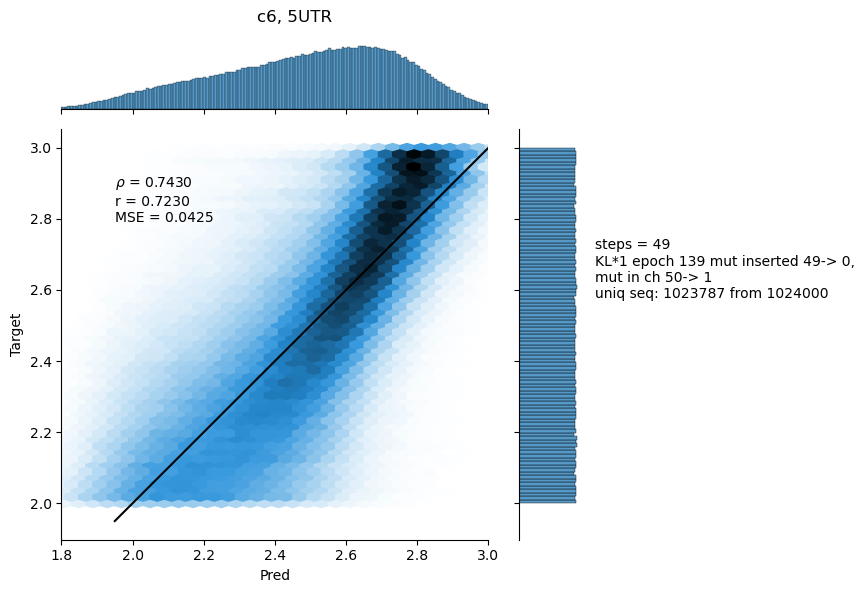

In [22]:
# small raw picture 
mode_comment = f'KL*{num} epoch {epoch} mut inserted {m_i_start}-> {m_i_end},\nmut in ch {in_start}-> {in_end}'
Sp_cor, P_cor, uniq = correlation_plot(pred_df, mode_comment, len(set(encoded_seqs)), epoch)


In [27]:
PATH_TO_CSV = f'./generated/cell_{CELL_TYPE_FILTER}_epoch_{epoch}_5UTR.csv'
pred_df.to_csv(PATH_TO_CSV, index=False)

-----------